In [6]:
from school_analysis.preprocessing.load import Loader
import pandas as pd


loader = Loader()
melted_df = loader.load('number_of_repeaters')

C:\Users\jonas\AppData\Local\Temp\ipykernel_8116\3798675982.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


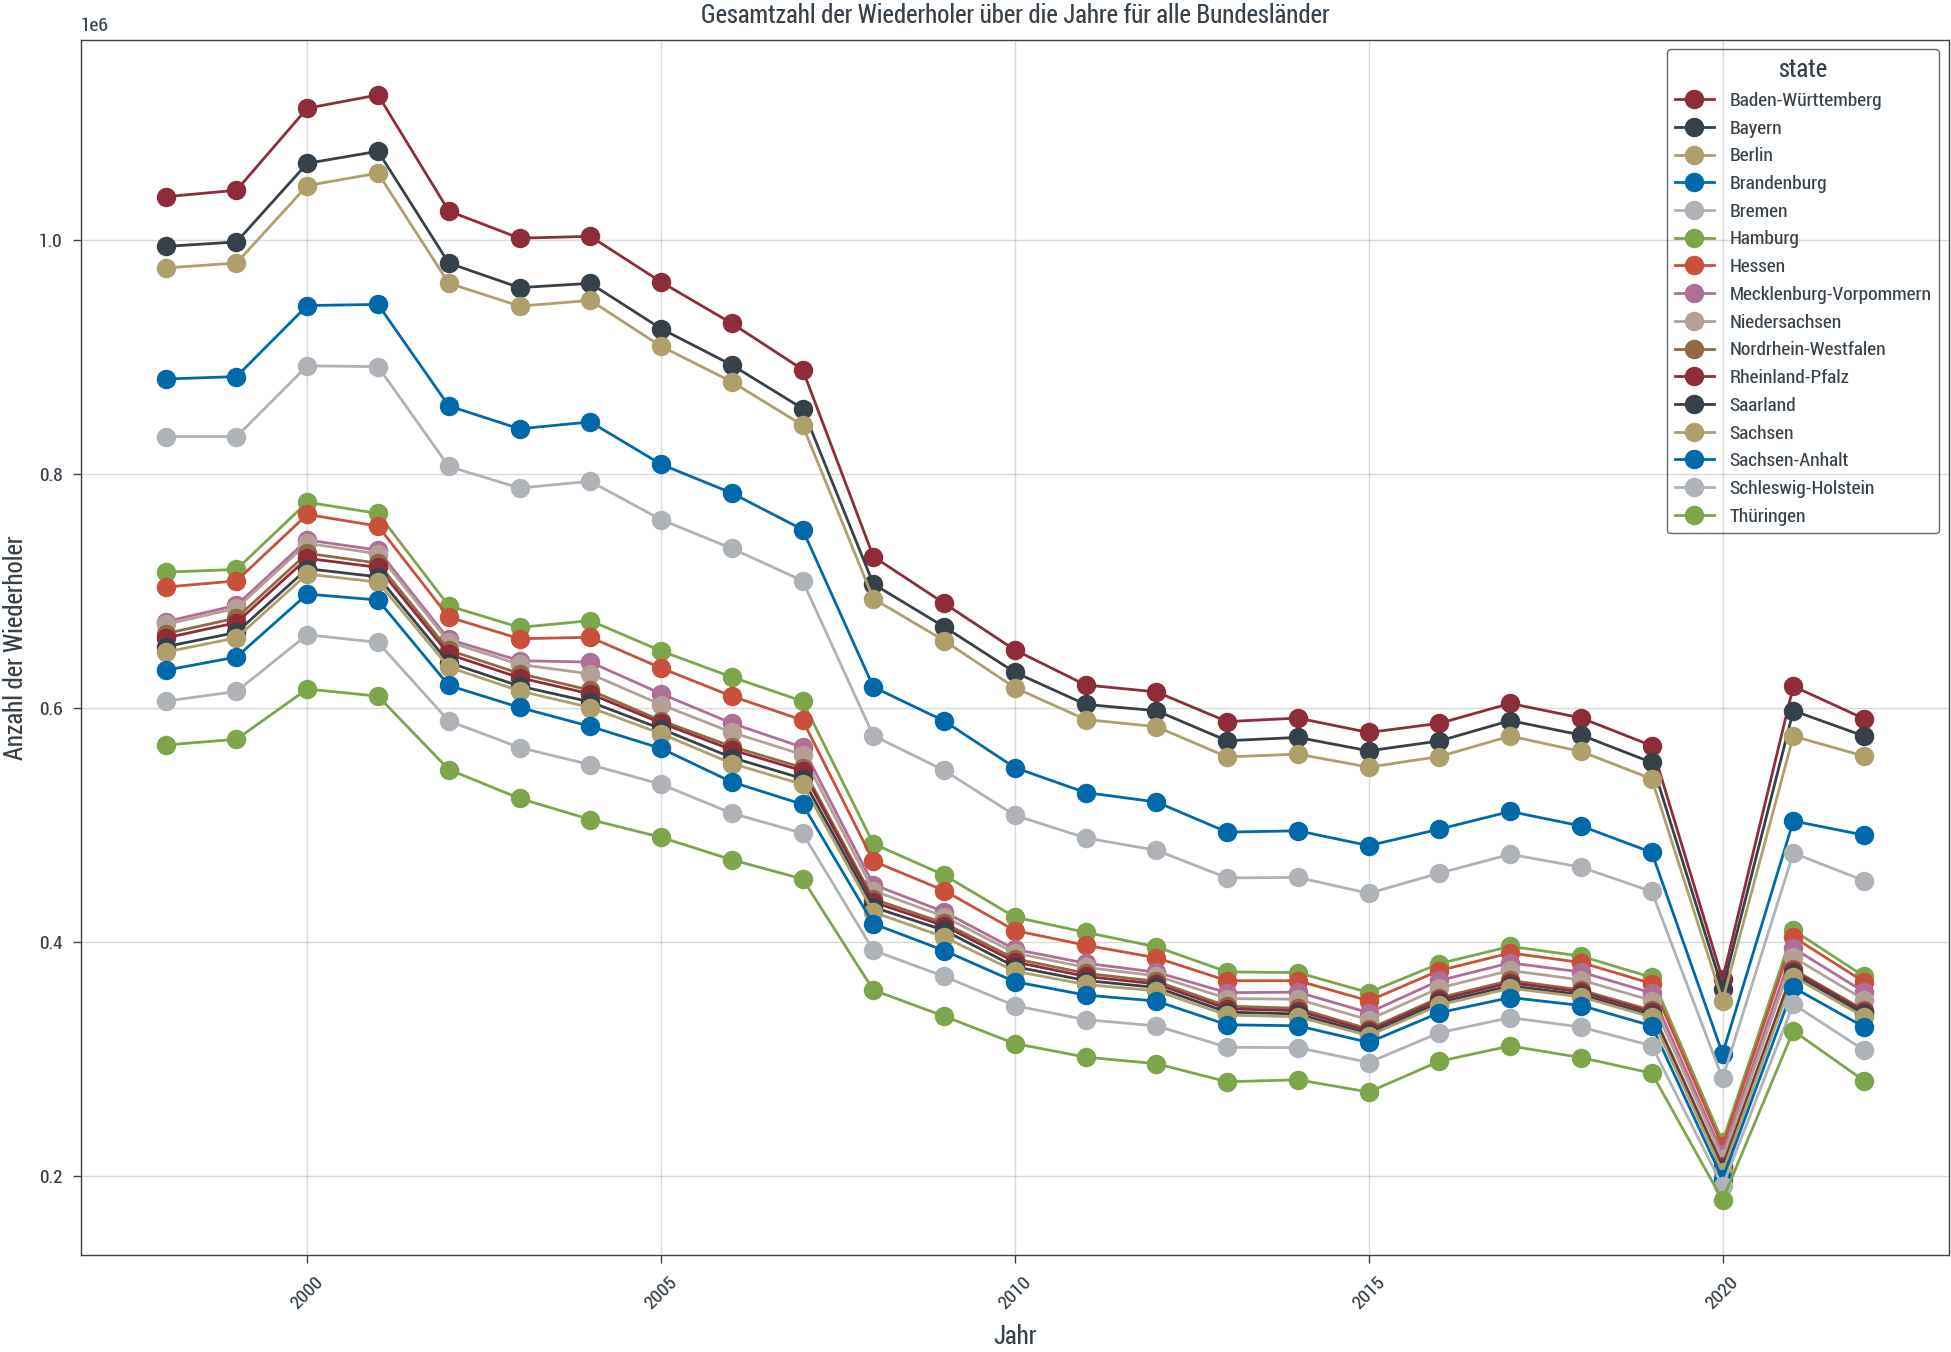

In [7]:
import matplotlib.pyplot as plt

melted_df['male'] = pd.to_numeric(melted_df['male'], errors='coerce')
melted_df['female'] = pd.to_numeric(melted_df['female'], errors='coerce')
melted_df['total'] = pd.to_numeric(melted_df['total'], errors='coerce')

total_repeaters_by_year_state = melted_df.groupby(['year', 'state'])['total'].sum().unstack()

total_repeaters_by_year_state.plot(kind='line', marker='o', figsize=(10, 7))
plt.title('Gesamtzahl der Wiederholer über die Jahre für alle Bundesländer')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Wiederholer')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\jonas\AppData\Local\Temp\ipykernel_8116\1851174864.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Stellt sicher, dass alles gut im Plot passt


<function matplotlib.pyplot.show(close=None, block=None)>

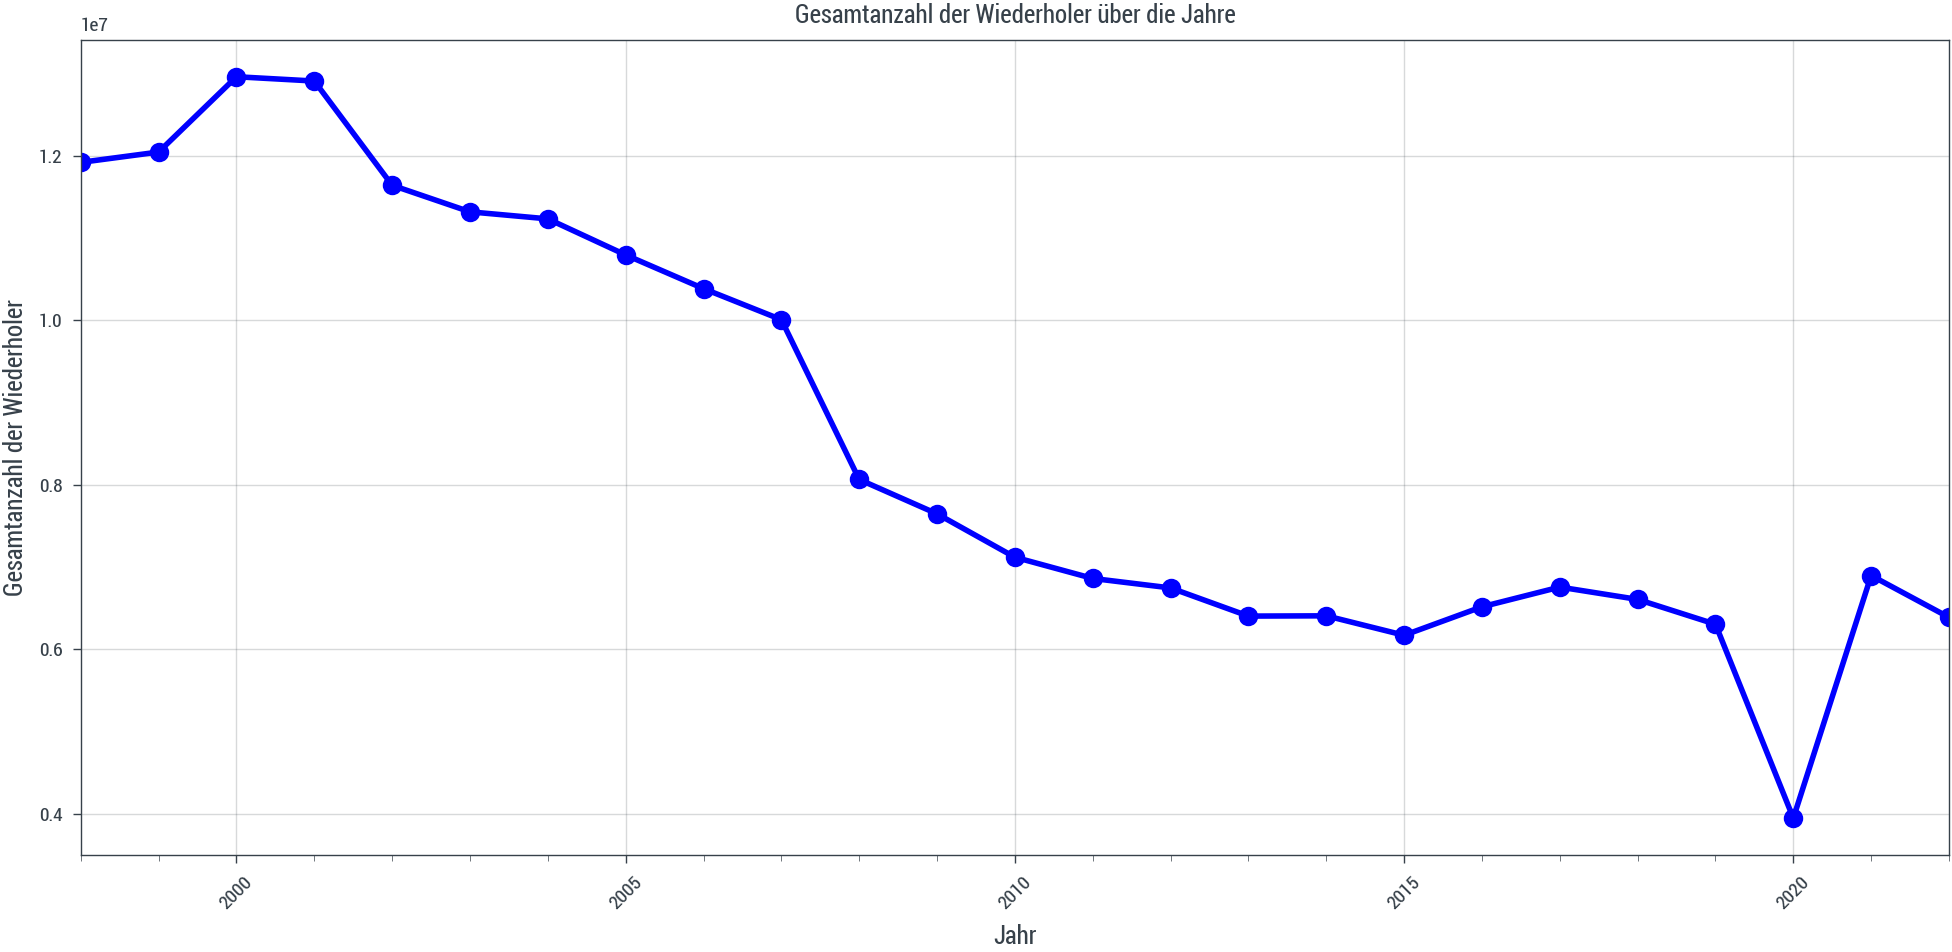

In [8]:
import matplotlib.pyplot as plt

melted_df['year'] = pd.to_datetime(melted_df['year'], format='%Y')

total_over_years = melted_df.groupby('year')['total'].sum()

plt.figure(figsize=(10, 5))
total_over_years.plot(kind='line', marker='o', color='blue', linewidth=2)
plt.title('Gesamtanzahl der Wiederholer über die Jahre')
plt.xlabel('Jahr')
plt.ylabel('Gesamtanzahl der Wiederholer')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Stellt sicher, dass alles gut im Plot passt
plt.show


C:\Users\jonas\AppData\Local\Temp\ipykernel_8116\3926578043.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


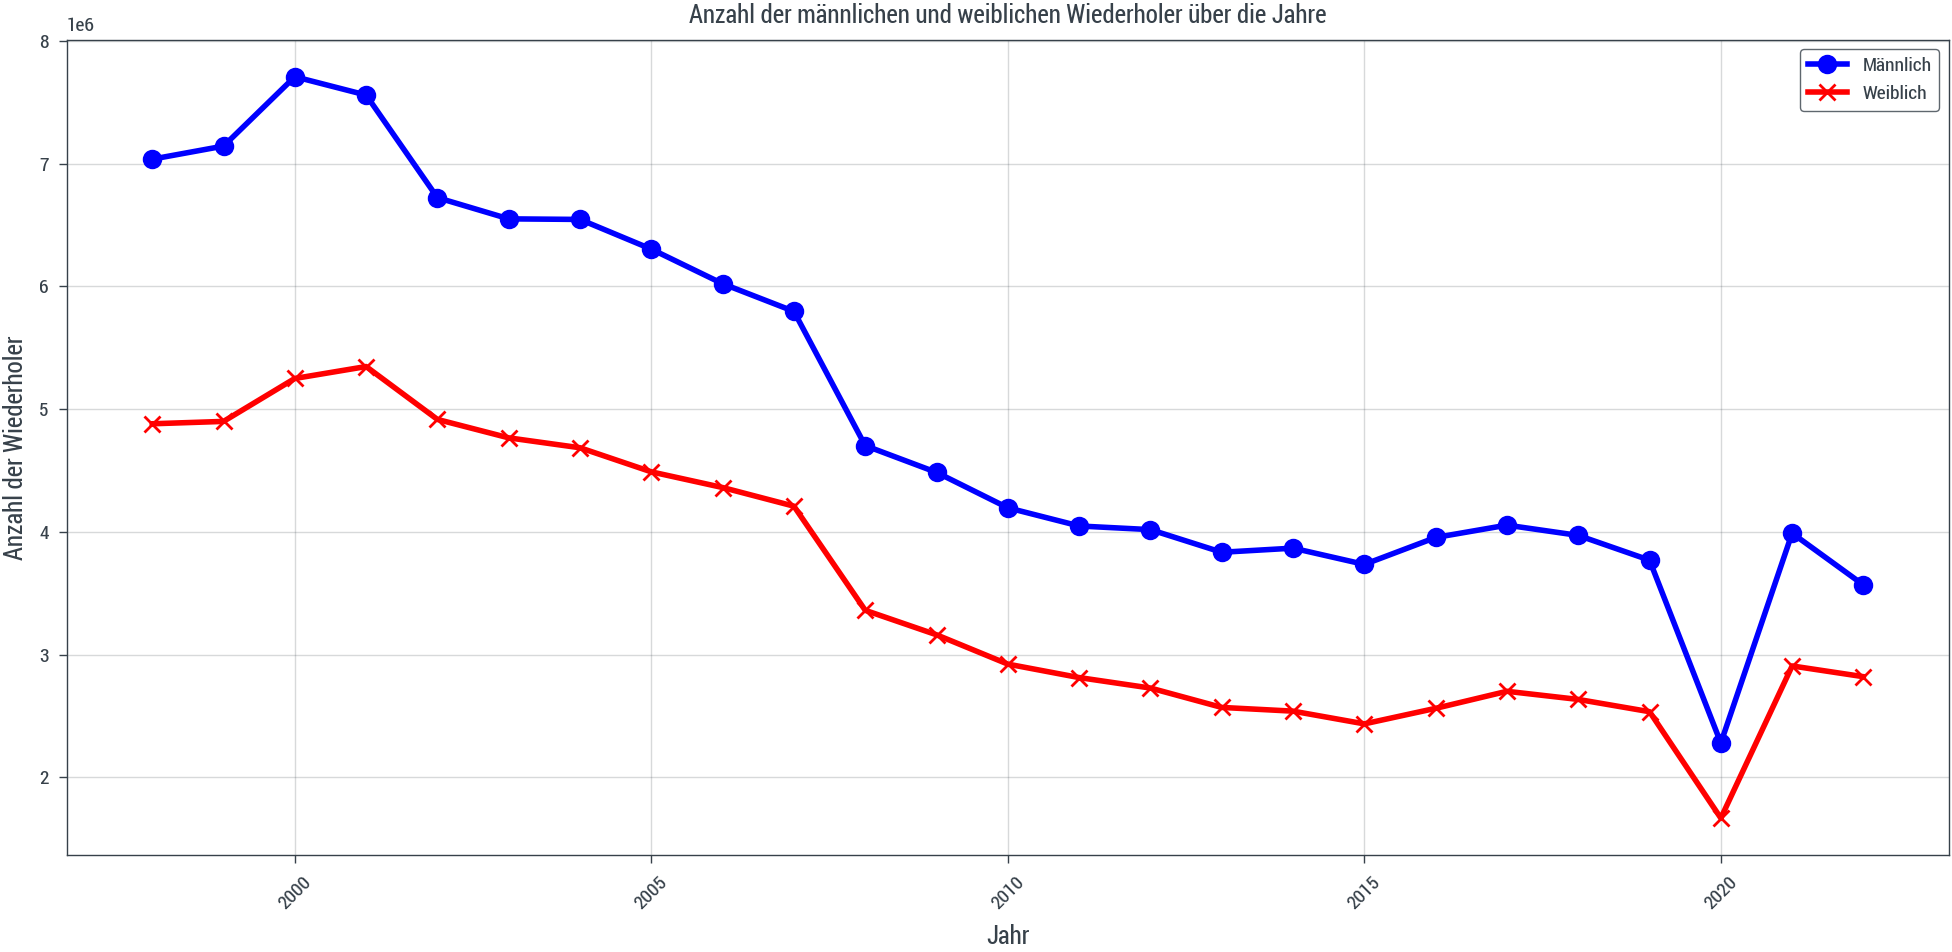

In [9]:
male_over_years = melted_df.groupby(melted_df['year'].dt.year)['male'].sum()
female_over_years = melted_df.groupby(melted_df['year'].dt.year)['female'].sum()

plt.figure(figsize=(10, 5))
male_over_years.plot(kind='line', marker='o', color='blue', linewidth=2, label='Männlich')
female_over_years.plot(kind='line', marker='x', color='red', linewidth=2, label='Weiblich')
plt.title('Anzahl der männlichen und weiblichen Wiederholer über die Jahre')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Wiederholer')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
